# Using The Super Resolution Convolutional Neural Network(Deep Neural N/W) for Image Restoration


In [1]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import numpy as np
import math
import os

# python magic function, displays pyplot figures in the notebook instead of separate display window
%matplotlib inline

# 1. Image Quality Metrics
The structural similiarity (SSIM) index was imported directly from the scikit-image library; however, we will have to define our own functions for the PSNR and MSE.

In [3]:
#define a function for peak signal-to-noise ratio (PSNR)
def psnr(target,ref):#target image and refernce image
    
    #assume RGB image and convert all integer values to float
    target_data=target.astype(float)
    ref_data=ref.astype(float)
    
    diff=ref_data-target_data
    diff=diff.flatten('C')#need ot flatten so computations can be done
    
    rmse=math.sqrt(np.mean(diff**2.))#2. for float values
    
    return 20*math.log10(255./rmse)

#define function for mean squared error(MSE)
def mse(target,ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err=np.sum((target.astype('float')-ref.astype('float'))**2)
    err=err/float(target.shape[0]*target.shape[1])#divided by total number of pixels
    
    return err

# define function that combines all three image quality metrics
def compare_images(target,ref):
    scores=[]
    scores.append(psnr(target,ref))
    scores.append(mse(target,ref))
    scores.append(ssim(target,ref,multichannel=True))#multichannel so that it can handle 3Dor 3 channel images RGB/BGR 
    
    return scores

# 2. Preparing Images


using the same images that were used in the original SRCNN paper. We can download these images from http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html.

In [9]:
import os
import cv2

# prepare degraded images by introducing quality distortions resizing

def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, c = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR) #interploation are methods for resizing images;how do you go from image with 100px to 1000px 
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)

In [10]:
prepare_images('source/',2)
#source folder has high resolution images that will be converted to low resoltion images to be used for SRCNN

Saving woman_GT.bmp
Saving monarch.bmp
Saving zebra.bmp
Saving lenna.bmp
Saving ppt3.bmp
Saving bird_GT.bmp
Saving face.bmp
Saving barbara.bmp
Saving baboon.bmp
Saving butterfly_GT.bmp
Saving foreman.bmp
Saving pepper.bmp
Saving baby_GT.bmp
Saving comic.bmp
Saving head_GT.bmp
Saving coastguard.bmp
Saving flowers.bmp


opencv is incredibly fast as it is designed for reat time computer vision application

new image(degraded) are of same resolution as base images.When sizing down the image we store the original pixel info in smaller area so we lost that info when sizing up the image.

# 3. Testing Low Resolution Images
To ensure that our image quality metrics are being calculated correctly and that the images were effectively degraded, lets calculate the PSNR, MSE, and SSIM between our reference images and the degraded images that we just prepared.

In [11]:
#test the generated umages using the image quality metrics

for file in os.listdir('images/'):
    
    #open target and reference images
    target=cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    #calculate scores
    scores=compare_images(target,ref)
    
     # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))
        

woman_GT.bmp
PSNR: 29.326236280817465
MSE: 227.812729498164
SSIM: 0.9335397280466592

monarch.bmp
PSNR: 30.196242365288896
MSE: 186.45643615722656
SSIM: 0.9439574293434104

zebra.bmp
PSNR: 27.909840639329513
MSE: 315.6585459528818
SSIM: 0.8911656209329116

lenna.bmp
PSNR: 31.47349297867539
MSE: 138.94800567626953
SSIM: 0.8460989200521499

ppt3.bmp
PSNR: 24.84926168950471
MSE: 638.6684263912582
SSIM: 0.9284023942315316

bird_GT.bmp
PSNR: 32.896644728720005
MSE: 100.12375819830247
SSIM: 0.9533644866026473

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.8008439492289884

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.8098632646406401

baboon.bmp
PSNR: 22.157084083442548
MSE: 1187.1161333333334
SSIM: 0.629277587900277

butterfly_GT.bmp
PSNR: 24.782076560337416
MSE: 648.6254119873047
SSIM: 0.8791344763843051

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883483270202
SSIM: 0.933268417388899

pepper.bmp
PSNR: 29.88947161686106
MSE: 200.1033935546875
SS

# 4. Building the SRCNN Model
 In Keras, it's as simple as adding layers one after the other. The achitecture and hyper parameters of the SRCNN network can be obtained from the publication referenced above.

In [12]:
# define the SRCNN model
def model():
    
    # define model type
    SRCNN = Sequential()
    
    #add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

# 5. Deploying the SRCNN
Now that we have defined our model, we can use it for single-image super-resolution, **AFTER** preprocessing the images extensively before using them as inputs to the network. This processing will include cropping and color space conversions.

Additionally, to save us the time it takes to train a deep neural network, we will be loading pre-trained weights for the SRCNN. These weights can be found at the following GitHub page: https://github.com/MarkPrecursor/SRCNN-keras

Once we have tested our network, we can perform single-image super-resolution on all of our input images. Furthermore, after processing, we can calculate the PSNR, MSE, and SSIM on the images that we produce. We can save these images directly or create subplots to conveniently display the original, low resolution, and high resolution images side by side.

In [13]:
# define necessary image processing functions

def modcrop(img,scale):
    tmpsz=img.shape
    sz=tmpsz[0:2]
    sz=sz-np.mod(sz,scale)
    img=img[0:sz[0],1:sz[1]]
    return img

def shave(image,border):
    img=image[border: -border,border:-border]
    return img

In [14]:
#define main prediction function

def predict(image_path):
    
    #load the srcnn model with weights
    srcnn=model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    #load the degraded and reference images
    path,file=os.path.split(image_path)
    degraded=cv2.imread(image_path)
    ref=cv2.imread('source/{}'.format(file))
    
    #preprocess the image with modcrop
    ref=modcrop(ref,3)
    degraded=modcrop(degraded,3)
    
    #convert the image to YCrCb - (srcnn trained on Y channel)
    temp=cv2.cvtColor(degraded,cv2.COLOR_BGR2YCrCb)
    
    #create image slice and normalize
    Y=numpy.zeros((1,temp.shape[0],temp.shape[1],1),dtype=float)
    Y[0,:,:,0]=temp[:,:,0].astype(float)/255
    
    #perform super-resolution with srcnn
    pre=srcnn.predict(Y,batch_size=1)
    
    #post-process output
    pre*=255
    pre[pre[:]>255]=255
    pre[pre[:]<0] =0
    pre=pre.astype(np.uint8)
    
    #copy Y channel back to image and convert to BGR
    temp=shave(temp,6)
    temp[:,:,0]=pre[0,:,:,0]
    output=cv2.cvtColor(temp,cv2.COLOR_YCrCb2BGR)
    
    #emove borderfrom reference and degraded image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

Degraded Image: 
PSNR: 27.248686459559124
MSE: 367.56400047398984
SSIM: 0.8690622024599293

Reconstructed Image: 
PSNR: 29.660196463036566
MSE: 210.95118497452304
SSIM: 0.8989098619482001



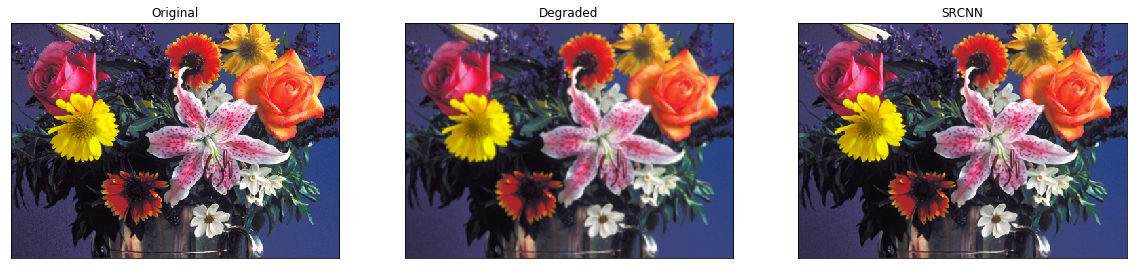

In [15]:
ref,degraded,output,scores=predict('images/flowers.bmp')
# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])